In [1]:
!pip install indic-nlp-library
!pip install scikit-multilearn

In [2]:
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git

Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 133 (delta 0), reused 2 (delta 0), pack-reused 126
Receiving objects: 100% (133/133), 149.77 MiB | 36.25 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [3]:
import sys
from indicnlp import common

# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"indic_nlp_resources"

# Add library to Python path
sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))

# Set environment variable for resources folder
common.set_resources_path(INDIC_NLP_RESOURCES)

In [4]:
import numpy as np
import pandas as pd
import csv
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [5]:
train_file = '../input/nlp-project-hindi/train.csv'
val_file = '../input/nlp-project-hindi/val.csv'

In [6]:
train_data = pd.read_csv(train_file, header=0, index_col=0)
val_data = pd.read_csv(val_file, header=0, index_col=0)

In [7]:
print(train_data.shape)
train_data.head()

(5727, 10)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post
Unique ID,,,,,,,,,,
1,मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...,"hate,offensive",[],[],[],[],"['🙏', '🙏']",[],[],मेरे देश के हिन्दु बहुत निराले है। कुछ तो पक्क...
2,सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...,non-hostile,[],['https://t.co/8iy2MJSBAs'],[],[],[],[],[],सरकार हमेशा से किसानों की कमाई को बढ़ाने के लि...
3,"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील...",non-hostile,[],"['https://t.co/G945HvzM0Z', 'https://t.co/KfH7...",[],['LIVE'],[],[],[],"सुशांत ने जो बिजनेस डील 9 जून को की थी, वो डील..."
4,@prabhav218 साले जेएनयू छाप कमिने लोग हिन्दुओं...,"defamation,offensive",[],[],['@prabhav218'],[],[],[],[],साले जेएनयू छाप कमिने लोग हिन्दुओं को यह कहते...
5,#unlock4guidelines - अनलॉक-4 के लिए गाइडलाइन्स...,non-hostile,[],['https://t.co/4e6lysg0VR'],[],['unlock4guidelines'],[],[],[],- अनलॉक-4 के लिए गाइडलाइन्स जारी\n\n- 7 सितंब...


In [8]:
print(val_data.shape)
val_data.head()

(811, 10)


,Post,Labels Set,emails,urls,mentions,hashtags,emojis,emoticons,reserved_words,Filtered_Post
Unique ID,,,,,,,,,,
1,दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए दे...,non-hostile,[],[],[],[],[],[],[],दृढ़ इच्छा शक्ति से परिपूर्ण प्रणबदा के लिए दे...
2,भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...,defamation,[],[],[],[],[],[],[],भारतीय जनता पार्टी rss वाले इतने गिरे हुए हैं ...
3,कोरोना से निपटने की तैयारी / दिल्ली में 10 हजा...,non-hostile,[],['https://t.co/9rlQowAsFh'],"['@ArvindKejriwal', '@rajnathsingh', '@AmitSha...",['Delhi'],[],[],[],कोरोना से निपटने की तैयारी / दिल्ली में 10 हजा...
4,गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीत...,non-hostile,[],['https://t.co/ZvKgxk6dbd'],[],[],[],[],[],गवर्नर कॉन्फ्रेंस में PM मोदी बोले- शिक्षा नीत...
5,"यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव...",non-hostile,[],['https://t.co/hxM1uNNmX2'],[],['UP'],[],[],[],"यूपी: गाजीपुर में Toilet घोटाला, प्रधान व सचिव..."


In [9]:
import ast

labels_set = {'defamation',
 'fake',
 'hate',
 'non-hostile',
 'offensive'}


## **Using one hot vectors of Emojis, Mentions and Hashtags**

In [10]:
# hashtags_set = defaultdict(int)

# ct=1
# for index, row in train_data.iterrows():
#   ht_list = ast.literal_eval(row['hashtags']) 
#   for ht in ht_list:
#     if hashtags_set.get(ht, 0)==0:
#       hashtags_set[ht] = ct
#       ct+=1

# emojis_set = defaultdict(int)
# ct=1
# for index, row in train_data.iterrows():
#   em_list = ast.literal_eval(row['emojis']) 
#   for em in em_list:
#     if emojis_set.get(em, 0)==0:
#       emojis_set[em] = ct
#       ct+=1

# mentions_set = defaultdict(int)
# ct=1
# for index, row in train_data.iterrows():
#   mn_list = ast.literal_eval(row['mentions']) 
#   for mn in mn_list:
#     if mentions_set.get(mn, 0)==0:
#       mentions_set[mn] = ct
#       ct+=1


## **Using per class counts for Emojis, Mentions and Hashtags**

In [11]:
hashtags_set = defaultdict(int)
emojis_set = defaultdict(int)
mentions_set = defaultdict(int)

for index, row in train_data.iterrows():
  ht_list = ast.literal_eval(row['hashtags'])
  em_list = ast.literal_eval(row['emojis'])
  mn_list = ast.literal_eval(row['mentions']) 

  for label in [x.strip() for x in row['Labels Set'].split(',')]:
    for ht in ht_list:
      hashtags_set[ht, label] +=1
    for em in em_list:
      emojis_set[em, label]+=1
    for mn in mn_list:
      mentions_set[mn, label]+=1

In [12]:
# print(len(emojis_set))
# print(len(hashtags_set))
# print(len(mentions_set))

In [13]:
# Creating Frequency Dictionary

vocab = defaultdict(int)
freqs = defaultdict(int)

for index, row in train_data.iterrows():
  for word in indic_tokenize.trivial_tokenize(row['Filtered_Post'], lang='hi'):
    vocab[word]+=1
    for label in [x.strip() for x in row['Labels Set'].split(',')]:
      freqs[word, label] +=1

len(freqs.keys())

35502

## **Using five class frequencies and other features as one hot vectors**

In [14]:
# def generate_train_matrix(train_data):
#   train_X = np.empty((0, 3350))

#   for index, row in train_data.iterrows():
#     x = np.zeros((1, 6))
#     x[0, 0] = 1  # Bias Unit
#     word_l = indic_tokenize.trivial_tokenize(row['Filtered_Post'], lang='hi')
    
#     for word in word_l:
#         x[0,1] += freqs.get((word,'defamation'),0)
#         x[0,2] += freqs.get((word, 'fake'),0)
#         x[0,3] += freqs.get((word,'hate'),0)
#         x[0,4] += freqs.get((word,'non-hostile'),0)
#         x[0,5] += freqs.get((word,'offensive'),0)

#     ht_list = ast.literal_eval(row['hashtags'])
#     hash_x = np.zeros((1, 1905))
#     for ht in ht_list:
#       idx = hashtags_set.get(ht, 0)
#       if idx!=0:
#         hash_x[0, idx-1] = 1

#     em_list = ast.literal_eval(row['emojis'])
#     emojis_x = np.zeros((1, 162))
#     for em in em_list:
#       idx = emojis_set.get(em, 0)
#       if idx!=0:
#         emojis_x[0, idx-1] = 1

#     mn_list = ast.literal_eval(row['mentions'])
#     mentions_x = np.zeros((1, 1277)) 
#     for mn in mn_list:
#         idx = mentions_set.get(mn, 0)
#         if idx!=0:
#           mentions_x[0, idx-1] = 1

#     x = np.hstack((x, hash_x, emojis_x, mentions_x))
    
#     train_X = np.vstack((train_X, x))

#   return train_X

## **Using only 5 class frequencies added up**

In [15]:
def generate_train_matrix(train_data):
  train_X = np.empty((0, 6))

  for index, row in train_data.iterrows():
    x = np.zeros((1, 6))
    x[0, 0] = 1  # Bias Unit
    word_l = indic_tokenize.trivial_tokenize(row['Filtered_Post'], lang='hi')
    
    for word in word_l:
        x[0,1] += freqs.get((word,'defamation'),0)
        x[0,2] += freqs.get((word, 'fake'),0)
        x[0,3] += freqs.get((word,'hate'),0)
        x[0,4] += freqs.get((word,'non-hostile'),0)
        x[0,5] += freqs.get((word,'offensive'),0)

    ht_list = ast.literal_eval(row['hashtags'])
    for ht in ht_list:
      x[0,1] += hashtags_set.get((ht,'defamation'),0)
      x[0,2] += hashtags_set.get((ht, 'fake'),0)
      x[0,3] += hashtags_set.get((ht,'hate'),0)
      x[0,4] += hashtags_set.get((ht,'non-hostile'),0)
      x[0,5] += hashtags_set.get((ht,'offensive'),0)

    em_list = ast.literal_eval(row['emojis'])
    for em in em_list:
      x[0,1] += emojis_set.get((em,'defamation'),0)
      x[0,2] += emojis_set.get((em, 'fake'),0)
      x[0,3] += emojis_set.get((em,'hate'),0)
      x[0,4] += emojis_set.get((em,'non-hostile'),0)
      x[0,5] += emojis_set.get((em,'offensive'),0)

    mn_list = ast.literal_eval(row['mentions'])
    for mn in mn_list:
      x[0,1] += mentions_set.get((mn,'defamation'),0)
      x[0,2] += mentions_set.get((mn, 'fake'),0)
      x[0,3] += mentions_set.get((mn,'hate'),0)
      x[0,4] += mentions_set.get((mn,'non-hostile'),0)
      x[0,5] += mentions_set.get((mn,'offensive'),0)
  
    train_X = np.vstack((train_X, x))

  return train_X

In [16]:
train_X = generate_train_matrix(train_data)
val_X = generate_train_matrix(val_data)

In [17]:
# Label Mapping
labels_mapping = {'defamation':0,
 'fake':1,
 'hate':2,
 'non-hostile':3,
 'offensive':4}


In [18]:
print(train_X.shape)
print(val_X.shape)

(5727, 6)
(811, 6)


In [19]:
train_X

array([[1.0000e+00, 3.9710e+03, 9.8850e+03, 6.1590e+03, 1.3608e+04,
        5.1190e+03],
       [1.0000e+00, 3.4880e+03, 8.2910e+03, 5.1970e+03, 1.6329e+04,
        4.0890e+03],
       [1.0000e+00, 4.3880e+03, 1.0814e+04, 6.8800e+03, 2.3133e+04,
        5.2940e+03],
       ...,
       [1.0000e+00, 3.4030e+03, 9.0420e+03, 5.4710e+03, 2.0386e+04,
        4.0690e+03],
       [1.0000e+00, 7.9800e+02, 2.0140e+03, 1.2810e+03, 3.0960e+03,
        9.5000e+02],
       [1.0000e+00, 8.4400e+02, 2.3740e+03, 1.2590e+03, 6.5550e+03,
        9.3300e+02]])

In [20]:
train_y = np.empty((0, 5))
for index, row in train_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  train_y = np.vstack((train_y, y))


val_y = np.empty((0, 5))
for index, row in val_data.iterrows():
  y = np.zeros((1, 5))
  for label in row['Labels Set'].split(','):
    y[0, labels_mapping[label]] = 1

  val_y = np.vstack((val_y, y))




In [21]:
print(train_y.shape)
print(val_y.shape)

(5727, 5)
(811, 5)


In [22]:
train_y

array([[0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

## **Binary Relevance Model**

In [23]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

classifier = BinaryRelevance(LogisticRegression(max_iter=150))
classifier.fit(train_X, train_y)

BinaryRelevance(classifier=LogisticRegression(max_iter=150),
                require_dense=[True, True])

In [24]:
predictions = classifier.predict(val_X)

In [25]:
predictions.shape

(811, 5)

In [26]:
val_y.shape

(811, 5)

In [27]:
def evaluation(y_true, y_pred):
  print("Fine Grained Accuracy = {}".format(accuracy_score(y_true, y_pred)))
  print("\n\nFine Grained Metrics\n")
  print(classification_report(y_true, y_pred))

  # y_true_coarse = np.zeros((y_true.shape[0], 2))
  # y_pred_coarse = np.zeros((y_true.shape[0], 2))

  # y_true_coarse_1 = y_true[:,3] 
  # y_true_coarse_0 = 1 - y_true_coarse[:,1]
  # y_true_coarse = np.hstack((y_true_coarse_0, y_true_coarse_1))
  
  # y_pred_coarse_1 = y_pred[:,3]
  # y_pred_coarse_0 = 1- y_pred_coarse[:,1]
  # y_pred_coarse = np.hstack((y_pred_coarse_0, y_pred_coarse_1))

  # print("Coarse Grained Accuracy = {}".format(accuracy_score(y_true_coarse, y_pred_coarse)))
  # print("\n\nCoarse Grained Metrics\n")
  # print(classification_report(y_true_coarse, y_pred_coarse))



In [28]:
evaluation(val_y, predictions)

Fine Grained Accuracy = 0.45499383477188654


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.10      0.01      0.02        77
           1       0.50      0.14      0.22       160
           2       0.36      0.11      0.17       110
           3       0.73      0.80      0.77       435
           4       0.39      0.11      0.17       103

   micro avg       0.67      0.45      0.54       885
   macro avg       0.42      0.23      0.27       885
weighted avg       0.55      0.45      0.46       885
 samples avg       0.47      0.48      0.47       885



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Indic Bert

In [29]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer


from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [30]:
# MODEL_NAME = 'ai4bharat/indic-bert'
# MODEL_NAME = 'monsoon-nlp/hindi-bert'

# MODEL_NAME = 'mrm8488/HindiBERTa'

In [31]:
# MODEL_NAME = 'meghanabhange/hinglish-indic-bert' #not working
# MODEL_NAME = 'meghanabhange/Hinglish-Bert-Class' 
# MODEL_NAME = 'meghanabhange/Hinglish-Bert'
# MODEL_NAME = 'meghanabhange/Hinglish-DistilBert-Class'
# MODEL_NAME = 'meghanabhange/Hinglish-DistilBert'
# MODEL_NAME = 'meghanabhange/hinglish-indic-bert' #not wokring
# MODEL_NAME = 'verloop/Hinglish-Bert-Class' # 0.58
MODEL_NAME = 'verloop/Hinglish-Bert' # 0.63
# MODEL_NAME = 'verloop/Hinglish-DistilBert-Class' # 0.41

In [32]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) 

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device) # Send the model to the GPU if we have one


# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )


# learning_rate = 1e-5
# optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [33]:
MODEL_NAME

'verloop/Hinglish-Bert'

In [34]:
# tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)#, do_lower_case=True)
# model = BertForSequenceClassification.from_pretrained(
#     MODEL_NAME, # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )
# model.cuda()

In [35]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [36]:
batch_size = 32
max_length = 256

In [37]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [38]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


### y_true and y_val

In [39]:
# # Label Mapping
# # labels_mapping = {'defamation':0,
# #  'fake':1,
# #  'hate':2,
# #  'non-hostile':3,
# #  'offensive':4}


# y_train_defamation = train_y[:,0].astype(int)
# y_train_fake = train_y[:,1].astype(int)
# y_train_hate = train_y[:,2].astype(int)
# y_train_non_hostile = train_y[:,3].astype(int)
# y_train_offensive = train_y[:,4].astype(int)

# y_val_defamation = val_y[:,0].astype(int)
# y_val_fake = val_y[:,1].astype(int)
# y_val_hate = val_y[:,2].astype(int)
# y_val_non_hostile = val_y[:,3].astype(int)
# y_val_offensive = val_y[:,4].astype(int)

In [40]:
# y_val_defamation[:4]

In [41]:
# train_sentences = train_data['Filtered_Post'].values
# train_labels = y_train_defamation

In [42]:
# val_sentences = val_data['Filtered_Post'].values
# val_labels = y_val_defamation

### Train data loading

In [43]:
def X_process(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_length,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])
    return input_ids, attention_masks


In [44]:
def train_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    train_dataset = TensorDataset(input_ids, attention_masks, labels)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    return train_dataloader

In [45]:
def val_load(input_ids, attention_masks, labels):
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    val_dataset = TensorDataset(input_ids, attention_masks, labels)
    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    
    return validation_dataloader

In [46]:
def train_fn(train_dataloader, validation_dataloader):
    
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            loss, logits = model(b_input_ids, 
                                 token_type_ids=None, 
                                 attention_mask=b_input_mask, 
                                 labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        
        y_pred = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                (loss, logits) = model(b_input_ids, 
                                       token_type_ids=None, 
                                       attention_mask=b_input_mask,
                                       labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            
#             labels = label_ids
            preds = logits
            pred_flat = np.argmax(preds, axis=1).flatten()
#             labels_flat = labels.flatten()
#             y_true.extend(labels_flat)
            y_pred.extend(pred_flat)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
        print(training_stats)
        
    return training_stats, y_pred


In [47]:
# def train_fn(train_dataloader, validation_dataloader):

#     # This training code is based on the `run_glue.py` script here:
#     # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

#     # Set the seed value all over the place to make this reproducible.
#     seed_val = 42

#     random.seed(seed_val)
#     np.random.seed(seed_val)
#     torch.manual_seed(seed_val)
#     torch.cuda.manual_seed_all(seed_val)

#     # We'll store a number of quantities such as training and validation loss, 
#     # validation accuracy, and timings.
#     training_stats = []

#     # Measure the total training time for the whole run.
#     total_t0 = time.time()

#     # For each epoch...
#     for epoch_i in range(0, epochs):

#         # ========================================
#         #               Training
#         # ========================================

#         # Perform one full pass over the training set.

#         print("")
#         print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#         print('Training...')

#         # Measure how long the training epoch takes.
#         t0 = time.time()

#         # Reset the total loss for this epoch.
#         total_train_loss = 0

#         # Put the model into training mode. Don't be mislead--the call to 
#         # `train` just changes the *mode*, it doesn't *perform* the training.
#         # `dropout` and `batchnorm` layers behave differently during training
#         # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#         model.train()

#         # For each batch of training data...
#         for step, batch in enumerate(train_dataloader):

#             # Progress update every 40 batches.
#             if step % 40 == 0 and not step == 0:
#                 # Calculate elapsed time in minutes.
#                 elapsed = format_time(time.time() - t0)

#                 # Report progress.
#                 print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#             # Unpack this training batch from our dataloader. 
#             #
#             # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#             # `to` method.
#             #
#             # `batch` contains three pytorch tensors:
#             #   [0]: input ids 
#             #   [1]: attention masks
#             #   [2]: labels 
#             b_input_ids = batch[0].to(device)
#             b_input_mask = batch[1].to(device)
#             b_labels = batch[2].to(device)

#             # Always clear any previously calculated gradients before performing a
#             # backward pass. PyTorch doesn't do this automatically because 
#             # accumulating the gradients is "convenient while training RNNs". 
#             # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#             model.zero_grad()        

#             # Perform a forward pass (evaluate the model on this training batch).
#             # The documentation for this `model` function is here: 
#             # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#             # It returns different numbers of parameters depending on what arguments
#             # arge given and what flags are set. For our useage here, it returns
#             # the loss (because we provided labels) and the "logits"--the model
#             # outputs prior to activation.
#             loss, logits = model(b_input_ids, 
#                                  token_type_ids=None, 
#                                  attention_mask=b_input_mask, 
#                                  labels=b_labels)

#             # Accumulate the training loss over all of the batches so that we can
#             # calculate the average loss at the end. `loss` is a Tensor containing a
#             # single value; the `.item()` function just returns the Python value 
#             # from the tensor.
#             total_train_loss += loss.item()

#             # Perform a backward pass to calculate the gradients.
#             loss.backward()

#             # Clip the norm of the gradients to 1.0.
#             # This is to help prevent the "exploding gradients" problem.
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#             # Update parameters and take a step using the computed gradient.
#             # The optimizer dictates the "update rule"--how the parameters are
#             # modified based on their gradients, the learning rate, etc.
#             optimizer.step()

#             # Update the learning rate.
#             scheduler.step()

#         # Calculate the average loss over all of the batches.
#         avg_train_loss = total_train_loss / len(train_dataloader)            

#         # Measure how long this epoch took.
#         training_time = format_time(time.time() - t0)

#         print("")
#         print("  Average training loss: {0:.2f}".format(avg_train_loss))
#         print("  Training epcoh took: {:}".format(training_time))

#         # ========================================
#         #               Validation
#         # ========================================
#         # After the completion of each training epoch, measure our performance on
#         # our validation set.

#         print("")
#         print("Running Validation...")

#         t0 = time.time()

#         # Put the model in evaluation mode--the dropout layers behave differently
#         # during evaluation.
#         model.eval()

#         # Tracking variables 
#         total_eval_accuracy = 0
#         total_eval_loss = 0
#         nb_eval_steps = 0

#         # Evaluate data for one epoch
#         for batch in validation_dataloader:

#             # Unpack this training batch from our dataloader. 
#             #
#             # As we unpack the batch, we'll also copy each tensor to the GPU using 
#             # the `to` method.
#             #
#             # `batch` contains three pytorch tensors:
#             #   [0]: input ids 
#             #   [1]: attention masks
#             #   [2]: labels 
#             b_input_ids = batch[0].to(device)
#             b_input_mask = batch[1].to(device)
#             b_labels = batch[2].to(device)

#             # Tell pytorch not to bother with constructing the compute graph during
#             # the forward pass, since this is only needed for backprop (training).
#             with torch.no_grad():        

#                 # Forward pass, calculate logit predictions.
#                 # token_type_ids is the same as the "segment ids", which 
#                 # differentiates sentence 1 and 2 in 2-sentence tasks.
#                 # The documentation for this `model` function is here: 
#                 # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
#                 # Get the "logits" output by the model. The "logits" are the output
#                 # values prior to applying an activation function like the softmax.
#                 (loss, logits) = model(b_input_ids, 
#                                        token_type_ids=None, 
#                                        attention_mask=b_input_mask,
#                                        labels=b_labels)

#             # Accumulate the validation loss.
#             total_eval_loss += loss.item()

#             # Move logits and labels to CPU
#             logits = logits.detach().cpu().numpy()
#             label_ids = b_labels.to('cpu').numpy()

#             # Calculate the accuracy for this batch of test sentences, and
#             # accumulate it over all batches.
#             total_eval_accuracy += flat_accuracy(logits, label_ids)


#         # Report the final accuracy for this validation run.
#         avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#         print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

#         # Calculate the average loss over all of the batches.
#         avg_val_loss = total_eval_loss / len(validation_dataloader)

#         # Measure how long the validation run took.
#         validation_time = format_time(time.time() - t0)

#         print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#         print("  Validation took: {:}".format(validation_time))

#         # Record all statistics from this epoch.
#         training_stats.append(
#             {
#                 'epoch': epoch_i + 1,
#                 'Training Loss': avg_train_loss,
#                 'Valid. Loss': avg_val_loss,
#                 'Valid. Accur.': avg_val_accuracy,
#                 'Training Time': training_time,
#                 'Validation Time': validation_time
#             }
#         )
#         print(training_stats)

#     return training_stats


In [48]:
def stats(training_stats):
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats


In [49]:
def plot_stats(df_stats):
    sns.set(style='darkgrid')

# Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()


In [50]:
# input_ids, attention_masks = X_process(train_sentences)
# train_dataloader = train_load(input_ids, attention_masks, train_labels)

# input_ids, attention_masks = X_process(val_sentences)
# validation_dataloader = val_load(input_ids, attention_masks, val_labels)

In [51]:
# from transformers import get_linear_schedule_with_warmup

# # Number of training epochs. The BERT authors recommend between 2 and 4. 
# # We chose to run for 4, but we'll see later that this may be over-fitting the
# # training data.
# epochs = 4

# # Total number of training steps is [number of batches] x [number of epochs]. 
# # (Note that this is not the same as the number of training samples).
# total_steps = len(train_dataloader) * epochs

# # Create the learning rate scheduler.
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps = 0, # Default value in run_glue.py
#                                             num_training_steps = total_steps)


In [52]:
# training_stats, y_pred_defamation = train_fn(train_dataloader, validation_dataloader)

In [53]:
# df_stats  = stats(training_stats)
# plot_stats(df_stats)

In [54]:
# df_stats

In [55]:
# len(y_pred_defamation)

In [56]:
# len(val_labels)

In [57]:
# Label Mapping
# labels_mapping = {'defamation':0,
#  'fake':1,
#  'hate':2,
#  'non-hostile':3,
#  'offensive':4}



In [58]:
# Label Mapping
# labels_mapping = {'defamation':0,
#  'fake':1,
#  'hate':2,
#  'non-hostile':3,
#  'offensive':4}


y_train_defamation = train_y[:,0].astype(int)
y_train_fake = train_y[:,1].astype(int)
y_train_hate = train_y[:,2].astype(int)
y_train_non_hostile = train_y[:,3].astype(int)
y_train_offensive = train_y[:,4].astype(int)

y_val_defamation = val_y[:,0].astype(int)
y_val_fake = val_y[:,1].astype(int)
y_val_hate = val_y[:,2].astype(int)
y_val_non_hostile = val_y[:,3].astype(int)
y_val_offensive = val_y[:,4].astype(int)

In [59]:
# train_sentences = train_data['Filtered_Post'].values
# val_sentences = val_data['Filtered_Post'].values


train_sentences = train_data['Post'].values
val_sentences = val_data['Post'].values

### Defamation

In [60]:
train_labels_defamation = y_train_defamation

In [61]:

val_labels_defamation = y_val_defamation

In [62]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_defamation)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_defamation)

In [63]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [64]:
training_stats, y_pred_defamation = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:32.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:35.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.28
  Training epcoh took: 0:02:21

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.27
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.2807468667043654, 'Valid. Loss': 0.26671773195266724, 'Valid. Accur.': 0.9028627622377622, 'Training Time': '0:02:21', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:02.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:05.

  Average training loss: 0.22
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.25
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.2807468667043654

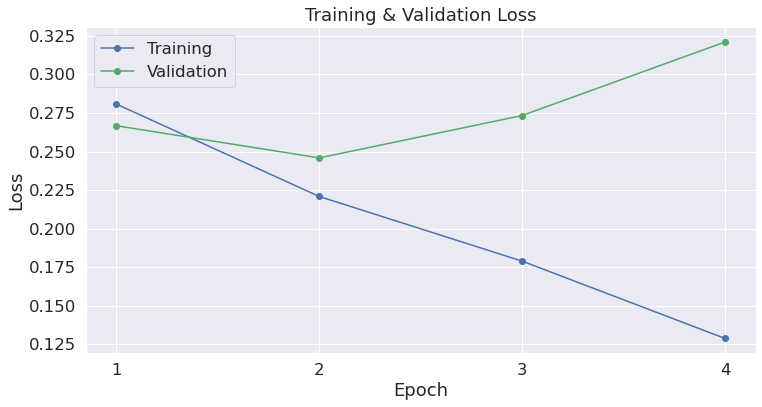

In [65]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [66]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.28,0.27,0.90,0:02:21,0:00:06
2,0.22,0.25,0.91,0:02:20,0:00:06
3,0.18,0.27,0.89,0:02:20,0:00:06
4,0.13,0.32,0.90,0:02:20,0:00:06


In [67]:
evaluation(y_val_defamation, y_pred_defamation)

Fine Grained Accuracy = 0.9001233045622689


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       734
           1       0.46      0.32      0.38        77

    accuracy                           0.90       811
   macro avg       0.70      0.64      0.66       811
weighted avg       0.89      0.90      0.89       811



### Fake

In [68]:
train_labels_fake = y_train_fake

In [69]:

val_labels_fake = y_val_fake

In [70]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_fake)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_fake)

In [71]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [72]:
training_stats, y_pred_fake = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:05.

  Average training loss: 0.33
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.23
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3323803229788162, 'Valid. Loss': 0.22668124541926843, 'Valid. Accur.': 0.9014423076923077, 'Training Time': '0:02:20', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:05.

  Average training loss: 0.20
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.20
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3323803229788162

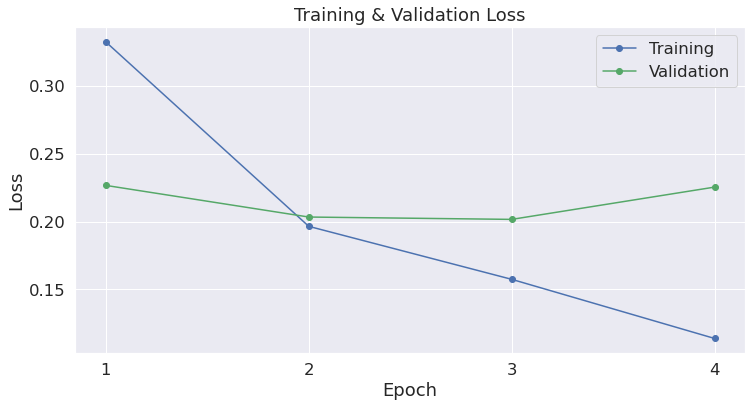

In [73]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [74]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.33,0.23,0.90,0:02:20,0:00:06
2,0.20,0.20,0.92,0:02:20,0:00:06
3,0.16,0.20,0.93,0:02:20,0:00:06
4,0.11,0.23,0.93,0:02:20,0:00:06


In [75]:
evaluation(y_val_fake, y_pred_fake)

Fine Grained Accuracy = 0.9297163995067818


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       651
           1       0.83      0.81      0.82       160

    accuracy                           0.93       811
   macro avg       0.89      0.88      0.89       811
weighted avg       0.93      0.93      0.93       811



### Hate

In [76]:
train_labels_hate = y_train_hate

In [77]:

val_labels_hate = y_val_hate

In [78]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_hate)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_hate)

In [79]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [80]:
training_stats, y_pred_hate = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.33
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.87
  Validation Loss: 0.34
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3321803235058678, 'Valid. Loss': 0.34339962613124114, 'Valid. Accur.': 0.8654938811188811, 'Training Time': '0:02:20', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.26
  Training epcoh took: 0:02:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.27
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3321803235058678

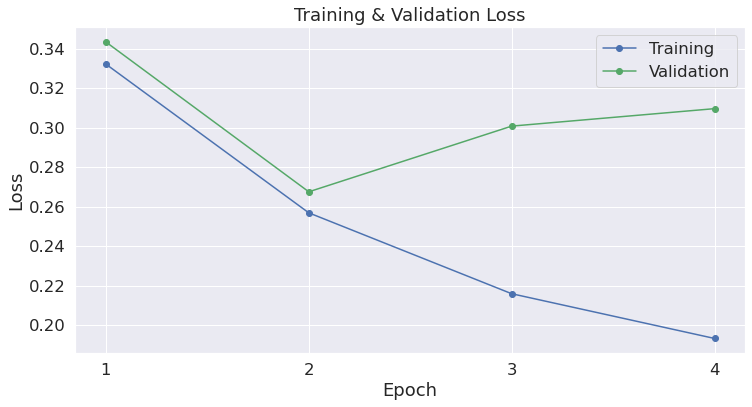

In [81]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [82]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.33,0.34,0.87,0:02:20,0:00:06
2,0.26,0.27,0.84,0:02:21,0:00:06
3,0.22,0.30,0.85,0:02:21,0:00:06
4,0.19,0.31,0.83,0:02:20,0:00:06


In [83]:
evaluation(y_val_hate, y_pred_hate)

Fine Grained Accuracy = 0.8310727496917386


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       701
           1       0.40      0.51      0.45       110

    accuracy                           0.83       811
   macro avg       0.66      0.70      0.68       811
weighted avg       0.85      0.83      0.84       811



### Non-Hostile

In [84]:
train_labels_non_hostile = y_train_non_hostile

In [85]:

val_labels_non_hostile = y_val_non_hostile

In [86]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_non_hostile)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_non_hostile)

In [87]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [88]:
training_stats, y_pred_non_hostile = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.36
  Training epcoh took: 0:02:21

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.20
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3581488943976147, 'Valid. Loss': 0.1982122603803873, 'Valid. Accur.': 0.9436188811188811, 'Training Time': '0:02:21', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.10
  Training epcoh took: 0:02:20

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.15
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3581488943976147,

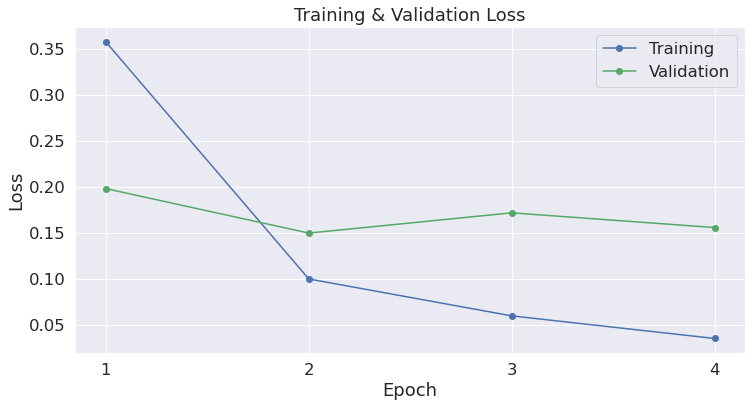

In [89]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [90]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.36,0.20,0.94,0:02:21,0:00:06
2,0.10,0.15,0.96,0:02:20,0:00:06
3,0.06,0.17,0.96,0:02:20,0:00:06
4,0.03,0.16,0.96,0:02:20,0:00:06


In [91]:
evaluation(y_val_non_hostile, y_pred_non_hostile)

Fine Grained Accuracy = 0.9617755856966708


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       376
           1       0.97      0.96      0.96       435

    accuracy                           0.96       811
   macro avg       0.96      0.96      0.96       811
weighted avg       0.96      0.96      0.96       811



### Offensive

In [92]:
train_labels_offensive = y_train_offensive

In [93]:

val_labels_offensive = y_val_offensive

In [94]:
input_ids, attention_masks = X_process(train_sentences)
train_dataloader = train_load(input_ids, attention_masks, train_labels_offensive)

input_ids, attention_masks = X_process(val_sentences)
validation_dataloader = val_load(input_ids, attention_masks, val_labels_offensive)

In [95]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [96]:
training_stats, y_pred_offensive = train_fn(train_dataloader, validation_dataloader)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:32.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.39
  Training epcoh took: 0:02:21

Running Validation...
  Accuracy: 0.88
  Validation Loss: 0.24
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3868245437491539, 'Valid. Loss': 0.23638457231796706, 'Valid. Accur.': 0.8836319930069929, 'Training Time': '0:02:21', 'Validation Time': '0:00:06'}]

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    179.    Elapsed: 0:00:31.
  Batch    80  of    179.    Elapsed: 0:01:03.
  Batch   120  of    179.    Elapsed: 0:01:34.
  Batch   160  of    179.    Elapsed: 0:02:06.

  Average training loss: 0.21
  Training epcoh took: 0:02:21

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.22
  Validation took: 0:00:06
[{'epoch': 1, 'Training Loss': 0.3868245437491539

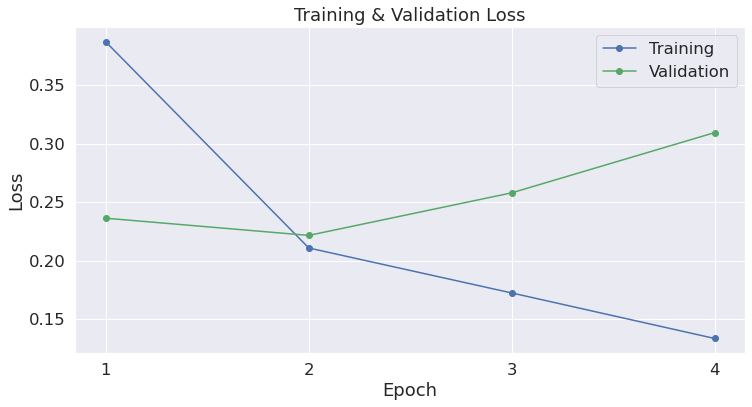

In [97]:
df_stats  = stats(training_stats)
plot_stats(df_stats)

In [98]:
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.39,0.24,0.88,0:02:21,0:00:06
2,0.21,0.22,0.90,0:02:21,0:00:06
3,0.17,0.26,0.89,0:02:21,0:00:06
4,0.13,0.31,0.89,0:02:21,0:00:06


In [99]:
evaluation(y_val_offensive, y_pred_offensive)

Fine Grained Accuracy = 0.8951911220715166


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       708
           1       0.60      0.53      0.56       103

    accuracy                           0.90       811
   macro avg       0.77      0.74      0.75       811
weighted avg       0.89      0.90      0.89       811



### Combine all 

In [100]:
# {'defamation':0,
#  'fake':1,
#  'hate':2,
#  'non-hostile':3,
#  'offensive':4}

In [101]:
y_pred = np.array((y_pred_defamation, y_pred_fake, y_pred_hate, y_pred_non_hostile, y_pred_offensive), dtype=int)

In [102]:
y_pred = y_pred.transpose()

In [103]:
evaluation(val_y, y_pred)

Fine Grained Accuracy = 0.6929716399506781


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.46      0.32      0.38        77
           1       0.83      0.81      0.82       160
           2       0.40      0.51      0.45       110
           3       0.97      0.96      0.96       435
           4       0.60      0.53      0.56       103

   micro avg       0.78      0.77      0.78       885
   macro avg       0.65      0.63      0.64       885
weighted avg       0.79      0.77      0.78       885
 samples avg       0.77      0.80      0.78       885



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
y = []

In [105]:
for i in range(len(y_pred_defamation)):
    t = []
    t.append(y_pred_defamation[i])
    t.append(y_pred_fake[i])
    t.append(y_pred_hate[i])
    t.append(y_pred_non_hostile[i])
    t.append(y_pred_offensive[i])
    y.append(t)

In [106]:
evaluation(val_y, y)

Fine Grained Accuracy = 0.6929716399506781


Fine Grained Metrics

              precision    recall  f1-score   support

           0       0.46      0.32      0.38        77
           1       0.83      0.81      0.82       160
           2       0.40      0.51      0.45       110
           3       0.97      0.96      0.96       435
           4       0.60      0.53      0.56       103

   micro avg       0.78      0.77      0.78       885
   macro avg       0.65      0.63      0.64       885
weighted avg       0.79      0.77      0.78       885
 samples avg       0.77      0.80      0.78       885

